In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *

import sympy as sym
import pandas as pd

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif( omega, f, n, bc ):
    '''
    Given the domain interval omega, 
    the forcing function f, 
    the number of discretization points n,
    the boundary conditions bc, 
    finDif returns the matrix A and the the right hand side b
    '''
    assert n>1
    assert omega[1]>omega[0]
    x=np.linspace(omega[0],omega[1],n)
    h = (omega[1]-omega[0])/(n-1)
    a2 = np.ones((n-2,)) # Offdiagonal entries
    a1 = -16 * np.ones((n-1,)) # Offdiagonal entries
    a0 = 30 * np.ones((n,)) # Diagonal entries
    A = (np.diag(a2, -2) + np.diag(a1, -1) + np.diag(a0, 0 )+ np.diag(a1, 1 )+ np.diag(a2, 2))/(12)
    b=f(x)
    # Change first row of the matrix A
    A[0,:] = 0
    A[:,0] = 0
    A[0,0] = 1
    b[0] = bc[0]/(h**2)
    # Change last row of the matrix A
    A[-1,:] = 0
    A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = bc[1]/(h**2)
    A = A / ( h**2 )
    return A, b

Call the function using:

In [3]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    '''
    LU retruns the LU factorization of the system matrix A
    '''
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    L=np.tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = np.triu(A)
    return L, U

L, U = LU(A)

In [5]:
def cholesky(A):
    '''
    cholesky retruns the Cholesky factorization of the system matrix A
    '''
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
    A[-1,-1] = np.sqrt(A[-1,-1])
    L=np.tril(A)
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = np.zeros_like(rhs)
    N = len(L)
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]
    return x

In [7]:
def U_solve(U,rhs):
    x = np.zeros_like(rhs)
    N=len(U)
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N)):
        x[i] = (rhs[i] - np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

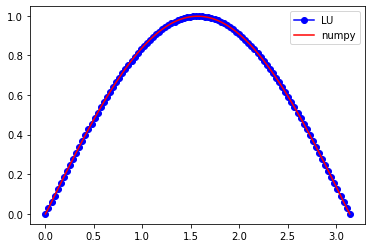

6.294964549624638e-14


In [8]:
x=np.linspace(omega[0],omega[1],n)
# My solution
w = L_solve(L,b)
u = U_solve(U,w)
# Numpy solution
u_ex = np.linalg.solve(A, b)
# Lets plot
_ = plot(x,u,'o-b', label="LU")
_ = plot(x,u_ex,'r', label="numpy")
legend()
show()
print(max(abs(u-u_ex)))

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

,n,error
0,2,0.000000
1,3,0.001042
2,4,0.001470
3,5,0.001371
4,6,0.001169
...,...,...
122,124,0.000052
123,125,0.000052
124,126,0.000052
125,127,0.000051


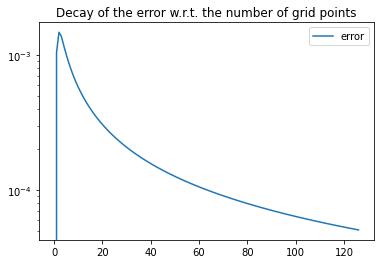

In [9]:
def calculate_error(omega, f, bc, Nmin, Nmax, f_exact):
    '''
    calculate the error between the LU solution and the function f_exact
    given:
    the interval omega
    the forcing force f
    the boundary condictions bc
    as a function of n integer in between Nmin and Nmax
    '''
    errors = []
    N=np.arange(Nmin,Nmax)
    error = 0.
    for n in range(Nmin,Nmax):
        x=np.linspace(omega[0],omega[1],n)
        A, b = finDif(omega, f, n, bc)
        L, U = LU(A)
        w = L_solve(L,b)
        u = U_solve(U,w)
        u_ex =f_exact(x)
        error=max(abs(u-u_ex))
        errors.append(error)
    return N,errors

# Plot the FD and exact solution
f_exact = lambda x :  (x**4)/12. - (x**3)/6. + x/12
omega2 = [0,1]
f2 = lambda x : x*(1-x)
bc2 = [0,0]
m,errors=calculate_error(omega2, f2, bc2, 2, 129, f_exact)
semilogy(errors, label="error")
title("Decay of the error w.r.t. the number of grid points")
legend()
df = pd.DataFrame({'n' : m, 'error' : errors})  
display(df)
# df.style

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [10]:
def IPM(A, x0, mu, tol, nmax ):
    '''
    Inverse power method with shift:  
    given the matrix A and vector x0, together with the shift mu
    IPM returns eigenvalue close to mu and the relative eigenvector
    with tolerance tol or after nmax iterations 
    '''
    M = A - mu * np.identity(len(A))
    L,U = LU(M)
    err = tol + 1.
    it = 0
    q = x0/(np.linalg.norm(x0,2))
    while it < nmax and err > tol :
        y = L_solve(L,q)
        x = U_solve(U,y)
        q = x/(np.linalg.norm(x,2))
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err =np.linalg.norm(z-l*q,2)
        it += 1
    return l,q

def PM(A, z0, tol, nmax):
    '''
    Power method:
    given A and z0
    PM returns the maximum eigenvalue and the associated eigenvector
    with tolerance tol
    or after nmax iterations
    '''
    q = z0/(np.linalg.norm(z0,2))
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        q = z/(np.linalg.norm(z,2))
        it += 1
    return l,q
    

def condNumb(A, eps, tol, nmax):
    '''
    condNumb returns the conditional number of the matrix A:
    it uses the power method to find the max eigenvalue
    and the Inverse power method with shift to find the minimum eigenvalue.
    The tolerance is tol and nmax is the max number of iterations.
    eps is a regulator for the Inverse power method.
    Actually, we look for the minimum eigenvalue close to zero (regulated by eps) 
    as our matrix is symmetric positve definite
    '''
    n = np.shape(A)[0]
    z0 = np.random.rand(n)
    lmin, _ = IPM(A, z0, eps, tol, nmax)
    lmax, _ = PM( A, z0, tol, nmax)
    condNu = lmax/lmin
    return condNu


print(condNumb(A, 1e-10, 1e-10, 10000 ))
print(np.linalg.cond(A))

5278.0687478114805
5278.068747922936


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

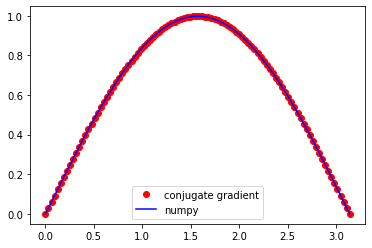

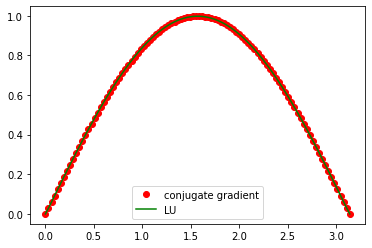

4.6407322429331543e-14
2.609024107869118e-14


In [11]:
def conjugate_gradient(A, b, P, nmax, eps):
    '''
    Preconditioned Conjugant Gradient method:
    Given the matrix A, the vector b and the preconditioner matrix P
    conjugate_gradient returns the solution of the original system 
    after nmax iterations 
    or with tolerance eps
    '''
    N=len(A)
    x = np.zeros_like(b)
    tol = eps + 1
    it = 0
    r = b - np.dot(A,x)
    rho_old = 1.
    p_old = np.zeros_like(b)
    while (it < nmax and tol > eps):
        it += 1
        z = np.linalg.solve(P,r)
        rho = np.dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = np.dot(A,p)
        alpha = rho/(np.dot(p,q))
        x += p*alpha
        r -= q*alpha
        p_old = p
        rho_old = rho
        tol = np.linalg.norm(r,2)    
    return x


# conjugate gradient solution
sol_conjugate_gradient = conjugate_gradient(A,b, np.identity(len(A)), np.shape(A)[0], 1e-10)
x=np.linspace(omega[0],omega[1],n)
# LU solution
L,U = LU(A)
w = L_solve(L,b)
u = U_solve(U,w)
# Numpy solution
u_ex = np.linalg.solve(A, b)
# Lets plot
_ = plot(x,sol_conjugate_gradient,'ro', label="conjugate gradient")
_ = plot(x,u_ex,'b', label="numpy")
legend()
show()
_ = plot(x,sol_conjugate_gradient,'ro', label="conjugate gradient")
_ = plot(x,u,'g', label="LU")
legend()
show()
print(max(abs(sol_conjugate_gradient-u_ex)))
print(max(abs(sol_conjugate_gradient-u)))

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


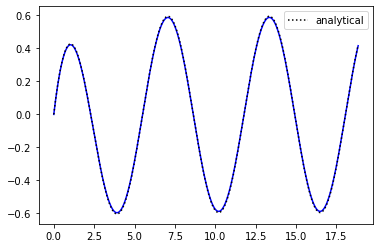

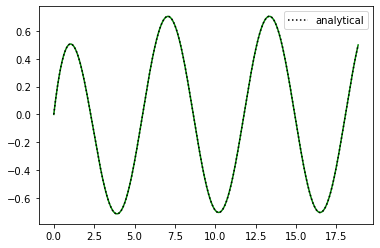

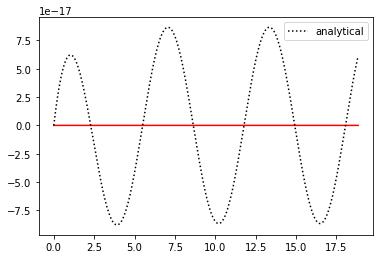

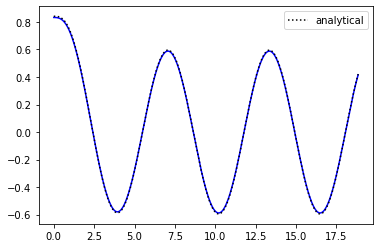

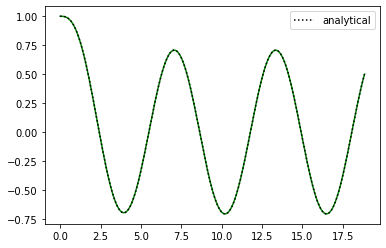

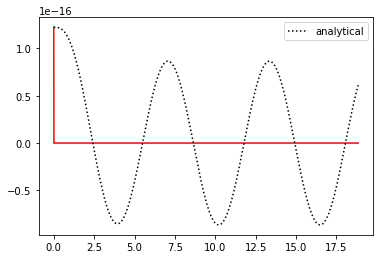

In [12]:
def fe_pde(omega_x, omega_t, bc, y0, h, n, f, eps ):
    '''
    Given the intervals omega_t and omega_x
    with boundary conditions y0 and bc
    h is the time distance between two consecutive nodes
    n is the number of spatial discretization points
    f is the forcing function
    eps a small parameter to calculate the timestep correctly
    fe_pde returns the solutions of the pde together with the timesteps and xsteps
    '''
    assert n > 0 
    assert h > 0
    A, b = finDif(omega_x, f, n, bc)
    timesteps = np.arange(omega_t[0],omega_t[1]+eps, h) 
    m = len(timesteps)
    sol = np.zeros((m,n))
    Au = np.zeros((m,n))
    xsteps=np.linspace(omega_x[0],omega_x[1],n)
    sol[0] = y0
    for i in range(0,m-1):
        Au[i] = np.dot(A,sol[i])   
        sol[i+1] = sol[i]  + h *(b*np.cos(timesteps[i])- Au[i] )
    return sol, timesteps, xsteps

def sol_x_fixed(sol, omega_x, x):
    assert x>= omega_x[0]
    assert x<= omega_x[1]
    n = np.shape(sol)[1]
    assert n>0
    x_index = int((n-1)*(x-omega_x[0])//(omega_x[1]-omega_x[0]))
    #if x_index<0: 
    #    x_index=0
    #if x_index>=n: 
    #    x_index=n-1    
    sol_x_fixed = sol[:,x_index]
    return sol_x_fixed

def sol_t_fixed(sol, omega_t, t):
    assert t>= omega_t[0]
    assert t<= omega_t[1]
    m = np.shape(sol)[0]
    assert m>0
    t_index = int((m-1)*(t-omega_t[0])//(omega_t[1]-omega_t[0]))
    #if t_index<0: 
    #    t_index=0
    #if t_index>=m: 
    #    t_index=m-1    
    sol_t_fixed = sol[t_index,:]
    return sol_t_fixed


### Boundary condition y0 = 0

f = lambda x : np.sin(x)
omega_x = [0,np.pi]
omega_t = [0,6*np.pi]
n=100
x=np.linspace(omega[0],omega[1],n)
z0 = np.ones_like(x)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
l_max,_ = PM(A,z0,1e-15,15000)
h = 0.0001
assert h < 2/ abs(l_max)
y0 = 0
sol, tsteps, xsteps = fe_pde(omega_x, omega_t, bc, y0, h, n, f, 1e-10)

# Comparison with exact solution
t= tsteps
sol_t = sol_x_fixed(sol, omega_x, 1)
plot(t,sol_t, 'blue')
plot(t,-(1/2)*np.exp(-t)*np.sin(1)+1/2*np.cos(t)*np.sin(1)+1/2*np.sin(t)*np.sin(1),'black',linestyle='dotted', label="analytical")
legend()
show()

sol_t = sol_x_fixed(sol, omega_x,np.pi/2)
plot(t,sol_t,'green')
plot(t,-(1/2)*np.exp(-t)*np.sin(np.pi/2)+1/2*np.cos(t)*np.sin(np.pi/2)+1/2*np.sin(t)*np.sin(np.pi/2),'black',linestyle='dotted', label="analytical")
legend()
show()

sol_t = sol_x_fixed(sol, omega_x,np.pi)
plot(t,sol_t, 'red')
plot(t,-(1/2)*np.exp(-t)*np.sin(np.pi)+1/2*np.cos(t)*np.sin(np.pi)+1/2*np.sin(t)*np.sin(np.pi),'black',linestyle='dotted', label="analytical")
legend()
show()

### Boundary condition y0 = sin(x)

f = lambda x : np.sin(x)

omega_x = [0,np.pi]
omega_t = [0,6*np.pi]
n=100
x=np.linspace(omega[0],omega[1],n)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
l_max,_ = PM(A,z0,1e-15,15000)
h = 0.0003
assert h < 2/ abs(l_max)
y0 = np.sin(x)

sol, tsteps, xsteps = fe_pde(omega_x, omega_t, bc, y0, h, n, f, 1e-10)

# Comparison with exact solution
t= tsteps
sol_t = sol_x_fixed(sol, omega_x, 1)
plot(t,sol_t, 'blue')
plot(t,(1/2)*np.exp(-t)*np.sin(1)+1/2*np.cos(t)*np.sin(1)+1/2*np.sin(t)*np.sin(1),'black',linestyle='dotted', label="analytical")
legend()
show()

sol_t = sol_x_fixed(sol, omega_x, np.pi/2)
plot(t,sol_t,'green')
plot(t,(1/2)*np.exp(-t)*np.sin(np.pi/2)+1/2*np.cos(t)*np.sin(np.pi/2)+1/2*np.sin(t)*np.sin(np.pi/2),'black',linestyle='dotted', label="analytical")
legend()
show()

sol_t = sol_x_fixed(sol, omega_x, np.pi)
plot(t,sol_t, 'red')
plot(t,(1/2)*np.exp(-t)*np.sin(np.pi)+1/2*np.cos(t)*np.sin(np.pi)+1/2*np.sin(t)*np.sin(np.pi),'black',linestyle='dotted', label="analytical")
legend()
show()
## Few differences but of the order of 1e-16




Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [13]:
def lu_eigvalues(A, tol, nmax=2000):
    """
    Given the matrix A lu_eigvalues returns the eigenvalues
    tolerance tol or after nmax iterations 
    """
    A_new=A.copy()
    n = np.shape(A_new)[0]
    eigvals_old = np.diag(A_new)
    it = 0
    err = tol + 1.
    while(it < nmax and err > tol ):
        L, U = LU(A_new)
        A_new = np.matmul(U,L)
        eigvals_new = np.diag(A_new) 
        err = np.linalg.norm(eigvals_new-eigvals_old,2)
        it = it + 1
        eigvals_old = eigvals_new
    return eigvals_new

def eig(A, eps, tol_eigevalues, nmax_eigevalues, tol_IPM, nmax_IPM):
    """
    eig returns eigenvalues and eigenvector of A
    eig first finds the approximated eigenvalues using LU decomposition (lueigvals)
    with tolerance tol_eigevalues or using nmax_eigevalues iterations 
    Then we use the Inverse power method with shift to find the true eigenvalues,
    close to the approximated eigenvalue found before (regulated by eps), 
    and the relative eigenvectors
    with tolerance tol_IPM or using nmax_IPM iterations
    """
    n = np.shape(A)[0]
    z0 = np.random.rand(n)
    eigvals = np.zeros(n)
    eigvecs = np.zeros((n,n))
    lueigvals = lu_eigvalues(A, tol_eigevalues, nmax_eigevalues)
    for i, qre in enumerate(lueigvals):
        eigvals[i], eigvecs[:,i] = IPM(A, z0, qre + eps, tol_IPM, nmax_IPM )
    return eigvals, eigvecs

l,v = eig(A, 1e-10, 1e-10, 2000, 1e-10, 10000 )
l_numpy,v_numpy = np.linalg.eig(A)
print(np.linalg.norm(np.sort(l)-np.sort(l_numpy),2))
print()
print(np.sort(v)-np.sort(v_numpy))
# The algorith is not efficient so in order to have good accuracy for the eigenvalues I need many of iterations
# Still with n=100 it is not enough for the eigenvectors to have good agreements with numpy

4.178889014719888e-11

[[-7.20411621e-21 -1.45274421e-21 -1.35417016e-23 ...  1.92891889e-14
   9.70505385e-01 -2.94946152e-02]
 [ 6.46704912e-15  2.71599240e-04  6.20630296e-04 ...  7.87744703e-04
   2.71599240e-04  2.80331314e-15]
 [ 5.31449403e-04  2.66743088e-04  5.24128173e-04 ...  4.00754068e-04
   1.05722987e-04  1.93576366e-05]
 ...
 [-5.25834692e-04 -7.90871262e-04 -1.08767096e-03 ... -4.62527954e-04
  -1.05722987e-04 -1.93576366e-05]
 [-6.81115014e-05 -1.20186035e-03 -1.85278659e-03 ... -6.81115014e-05
   1.01030295e-14  2.85882429e-15]
 [-1.78954631e-21 -3.60870503e-22 -3.36384109e-24 ...  4.79155190e-15
   2.41079444e-01 -7.58920556e-01]]


Compute the inverse of the matrix A exploiting the derived LU factorization

In [14]:
def inverse(A):
    """
    inverse returns the inverse of the matrix A
    """
    m = np.shape(A)[0]
    Ainv= np.ones_like(A)
    L,U = LU(A)
    for j in range(m):
        e=np.zeros((m,))
        e[j]=1
        winv = L_solve(L,e)
        uinv = U_solve(U,winv)
        Ainv[:,j]=uinv
    return Ainv    

Ainv = inverse(A)
Ainv_numpy = np.linalg.inv(A)
print(np.linalg.norm(Ainv-Ainv_numpy,2))

6.492862786734044e-14


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

0.01808450545115159 0.015748721108820307


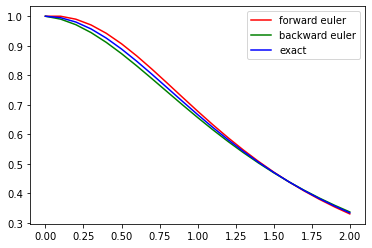

In [15]:
def newton(f, f_prime, x0, eps, n_max):
    '''
    Newton's method:
    f: function
    f_prime: derivative of the function
    x0: initial point
    eps: tolerance
    n_max: max number of iterations
    '''
    err = abs(f(x0))
    it = 0
    x = x0
    while (err > eps and it < n_max):
        if abs(f_prime(x)) < 1e-12:
            raise RuntimeError("f_prime(x) is close to zero")
        x_new = x - f(x)/f_prime(x)
        err = abs(f(x_new))
        x = x_new
        it += 1
    return x

def fe(t0, tf, h, y0, eps=1e-10):
    '''
    Forward Euler's method:
    given
    t0:  initial time
    tf:  final time
    h:   time distance between two consecutive nodes
    y0:  boundary condition at y[t0]
    eps: small epsilon to calculate the time steps correctly
    fe returns the solution of the ODE and the timesteps
    '''
    timesteps = np.arange(t0,tf+eps, h)
    sol = np.zeros_like(timesteps)
    sol[0] = y0
    for i in range(1,len(sol)):
        sol[i] = sol[i-1] - h * timesteps[i-1] * sol[i-1]**2   
    return sol, timesteps


def be(t0, tf, h, y0, tol=1e-10, nmax=1000, eps=1e-10):
    """
    Backward Euler's method:
    given
    t0: initial time
    tf: final time
    h: the time distance between two consecutive nodes
    y0: boundary condition at y[t0]
    tol: tolerance for the iterations
    nmax: max number of iterations
    eps: small epsilon to calculate the time steps correctly
    be returns the solution of the ODE and the timesteps
    """
    timesteps = np.arange(t0, tf + eps, h)
    sol = np.zeros_like(timesteps)
    sol[0] = y0
    it = 0
    for i in range(len(sol)-1):
        t = sym.symbols('t')
        f_sym = t - sol[i] + h * timesteps[i+1] * t**2 
        f_prime_sym = sym.diff(f_sym,t)
        f = sym.lambdify(t, f_sym, 'numpy')
        f_prime = sym.lambdify(t, f_prime_sym, 'numpy')
        sol[i+1] = newton(f, f_prime, sol[i], tol, nmax) 
    return sol, timesteps

l = -5.
t0 = 0.
tf = 2.
y0 = 1.
s = np.linspace(t0,tf,100)
h=0.1
#h=0.01
f_exact = lambda x: 2/(2 + x**2)
f_fe, t = fe(t0, tf, h, y0)
f_be, t = be(t0, tf, h, y0)
_ = plot(t, f_fe, 'r', label="forward euler")
_ = plot(t, f_be, 'g', label="backward euler")
_ = plot(t, f_exact(t), 'b', label="exact")
legend()
error1 = max(abs(f_exact(t) - f_fe))
error2 = max(abs(f_exact(t) - f_be))
print(error1, error2)